# Transfer learning walkthrough using Pytorch
> Implement transfer learning using pre-trained CNN

- toc:true
- badges: true
- comments: true
- author: Pushkar G. Ghanekar
- categories: [python, data-analysis, machine-learning]

## What is transfer learning? 

Transfer learning is a technique where a deep-learning model trained on another problem (which usually has lot of data and good accuracy for that task) is slightly modified to be used on a new problem. This is an important concept as building an entirely new model might not be take a long time or there might not be enough data for the training of that particular task. The idea is the weights/parameters of the model at the start of the layers have similar functionality and assist in better performance on the new task. Usually we freeze the weights training of the hidden layers an tweak the output layer slightly to account for the change in the task.

So for example, maybe you could have the neural network learn to recognize objects like cats and then use that knowledge or use part of that knowledge to help you do a better job reading x-ray scans. This is called transfer learning. Sometimes you can start with the weights and biases of a published netowrks as a starting point. 

More details about Transfer Learning can be found on Stanford's CS231 CNN course [here](https://cs231n.github.io/transfer-learning/)

In this example I use a pre-trained convolutional neural network model (ResNet-18) and modify ONLY the last layers of the model to use for our case. This model is trained on millions on images with 1000 image categories. 

These two major transfer learning scenarios look as follows:

* **Finetuning the convnet:** Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

* **ConvNet as fixed feature extractor:** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

This tutorial was adapted from PyTorch's official documentation [(Link)](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [7]:
import time 
import os 
import copy 
import matplotlib.pyplot as plt
import numpy as np 

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# Plot matplotlib plots with white background: 
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [9]:
# Define pre-processing steps for the image before being converted to Tensors
# As defined on the tutorial page 

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [10]:
data_dir = 'data/hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [11]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [12]:
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


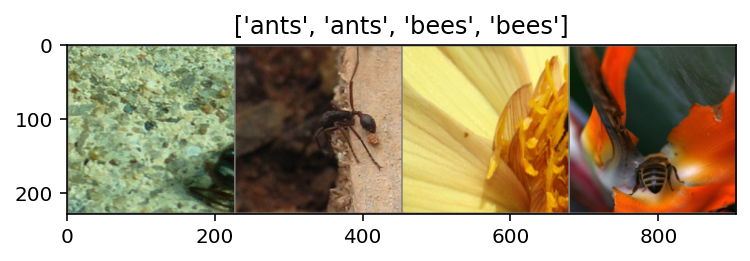

In [13]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step() #Step in the scheduler 

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model for which val_acc is better 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Method 1: Fine tuning of the model -- 
> Download a pretrained model, tweak the model architecture for our use-case, and (re)train on the new dataset 

1. Download the model (ResNet18 in this case) 
2. Change the output of the final layer  -- in this case from 1000 output nodes to 2 since we're looking at only 'bee' and 'ant'
3. Re-train the model 

Other models available from PyTorch can be viewed [(here)](https://pytorch.org/vision/stable/models.html)

In [18]:
#Load a pre-trained model -- ResNet18 model 
model = torchvision.models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We're interested to only change the final layer named `fc` -- so we will look at that layers features, the attributes for each module in the model are stored as keys. 

In [21]:
num_features = model.fc.in_features

# Define a new linear layer as per our need -- 2 classes instead of 1000 as defined in the original 
model.fc = nn.Linear(num_features, len(class_names)) #Number of classes in the end 

# Send model to device 
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Scheduler to update the learning rate for the SGD 
'''
After every 7 steps in the optimizer the learning rate will be multiplied by 0.1 
'''
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1) 

In [23]:
model = train_model(model, criterion=criterion, optimizer=optimizer, scheduler=step_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 1.0695 Acc: 0.5000
val Loss: 0.6179 Acc: 0.6340

Epoch 1/4
----------
train Loss: 0.7267 Acc: 0.5820
val Loss: 0.8217 Acc: 0.5948

Epoch 2/4
----------
train Loss: 0.6941 Acc: 0.6230
val Loss: 0.8131 Acc: 0.6667

Epoch 3/4
----------
train Loss: 0.6948 Acc: 0.5902
val Loss: 1.6474 Acc: 0.5882

Epoch 4/4
----------
train Loss: 0.6834 Acc: 0.6270
val Loss: 0.9145 Acc: 0.6275

Training complete in 5m 11s
Best val Acc: 0.666667


### Method 2: Freeze penultimate weights
In this case ONLY the weights of the final layer are trained. This might reduce the accuracy but would greatly reduce the amount of time taken to fit the model since the number of weights to be optimized is greatly reduced. 

In [24]:
#Load a pre-trained model -- ResNet18 model 
model = torchvision.models.resnet18(pretrained=True)

In [25]:
#Method to freeze the layer parameters -- just get the require grad attribute to FALSE!  
for param in model.parameters(): 
    param.requires_grad = False 

In [26]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) #Number of classes in the end 
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

This block is same as before

In [27]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.001)

#Scheduler to update the learning rate for the SGD 
'''
After every 7 steps in the optimizer the learning rate will be multiplied by 0.1 
'''
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1) 

Model training 

In [28]:
model = train_model(model, criterion=criterion, optimizer=optimizer, scheduler=step_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6937 Acc: 0.5615
val Loss: 0.5267 Acc: 0.7974

Epoch 1/4
----------
train Loss: 0.5915 Acc: 0.7008
val Loss: 0.4388 Acc: 0.8627

Epoch 2/4
----------
train Loss: 0.5249 Acc: 0.7623
val Loss: 0.3686 Acc: 0.9216

Epoch 3/4
----------
train Loss: 0.5079 Acc: 0.7664
val Loss: 0.3188 Acc: 0.9477

Epoch 4/4
----------
train Loss: 0.4556 Acc: 0.8115
val Loss: 0.3007 Acc: 0.9281

Training complete in 2m 18s
Best val Acc: 0.947712


Using fine-tuning and re-training all the weights for the new network take longer and may result in lower acceracy than having the weights fixed. When we keep the weights in earlier layers fixed, we save a lot of time in the model training aand the performance of the model is also better (provided the two tasks are quite similar). Given the network is deep, optimizing the weights for this network from scratch would have been difficult and time consuming. For such a case, transfer learning seems to be a good option. 